In [1]:
import sys
sys.path.append('..')

In [2]:
from data import dataset, generate_data
from models import RSSM, MultiRSSM, VCD
import json
from jax import random
from jax import numpy as jnp
from matplotlib import pyplot as plt
from experiments import evaluation
import numpy as np
import jax


This following script loads trained models and evaluate their rollout accuracy. 

Each test episode is 100 frames long. The models get observations for the first 50 frames and perform prediction purely in the latent space in the final 50 frames.

Errors are measured as L2 distance in the pixel space.

In [3]:
data_conf = json.load(open('../data/image_data_conf.json'))
mixing_matrix = random.normal(random.PRNGKey(0), (8, 12))
mixing_function = lambda x: x @ mixing_matrix

test_data_config = data_conf['test_data_conf']
mixing_function = lambda x: x / 255
test_data = dataset.DataLoader(
    generate_data.get_images,
    test_data_config,
    50,
    data_conf["test_data_seed"],
    mixing_function,
)

In [4]:
# change the below to the logging directories and the checkpoint ids for the models.
rssm_path = '../pretrain/image_rssm'
rssm_chkpt_id = 0
vcd_path = '../pretrain/image_vcd'
vcd_chkpt_id = 0

rssm_error = evaluation.image_rollout_error(test_data, RSSM.ImageRSSM, rssm_path, rssm_chkpt_id, 50, None)
vcd_error = evaluation.image_rollout_error(test_data, VCD.ImageVCD, vcd_path, vcd_chkpt_id, 50, None)

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


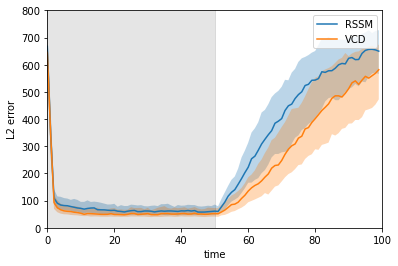

In [6]:
plt.plot(jnp.median(rssm_error, axis=(1,2)), label='RSSM')
plt.fill_between(jnp.arange(100), jnp.quantile(rssm_error, 0.75, axis=(1,2)), jnp.quantile(rssm_error, 0.25, axis=(1,2)), alpha=0.3)
plt.plot(jnp.median(vcd_error, axis=(1,2)), label='VCD')
plt.fill_between(jnp.arange(100), jnp.quantile(vcd_error, 0.75, axis=(1,2)), jnp.quantile(vcd_error, 0.25, axis=(1,2)), alpha=0.3)
plt.fill_betweenx([0,1000], [0,0], [50,50], color='k', alpha=0.1)
plt.ylim([0, 800])
plt.xlim([0,100])
plt.xlabel('time')
plt.ylabel('L2 error')
plt.legend()